In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import nci
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from models import AffinityModel
from sklearn.model_selection import train_test_split

/Users/jessemurray/Desktop/Main/Rotation1/Code/torchani/torchani/aev.py:18: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/Users/jessemurray/Desktop/Main/Rotation1/Code/torchani/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


In [104]:
def get_G_R(cutoff='cos', r_c=12, eta=np.logspace(-3, 0, num=4), r_s=np.arange(2, 12, 2)):
    assert cutoff in ('cos', 'tanh')
    x = r_c * np.linspace(0, 1, 10_000)
    if cutoff == 'cos':
        f_c = 0.5 * np.cos(np.pi * x / r_c) + 0.5
    elif cutoff == 'tanh':
        f_c = (np.tanh(1 - x / r_c))**3
    G_R = np.expand_dims(f_c, (1, 2)) * np.exp(-eta * np.expand_dims(np.square(x.reshape(-1, 1) - r_s), -1))
    return x, r_s, eta, G_R

In [124]:
def plot_radial(G_R_out):
    x, r_s, eta, G_R = G_R_out
    if eta.size == 1:
        fig, axs = plt.subplots(1, 1, figsize=(12, 12))
    elif eta.xize == 2:
        fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    for i in range(eta.size):
        try:
            ax = axs.ravel()[i]
        except AttributeError:
            ax = axs
        df_i = pd.DataFrame(G_R[:, :, i], columns=r_s.astype('str'), index=x)
        sns.lineplot(ax=ax, data=df_i)
        ax.legend(title=f'$r_s$, $\eta$ = {eta[i]}')

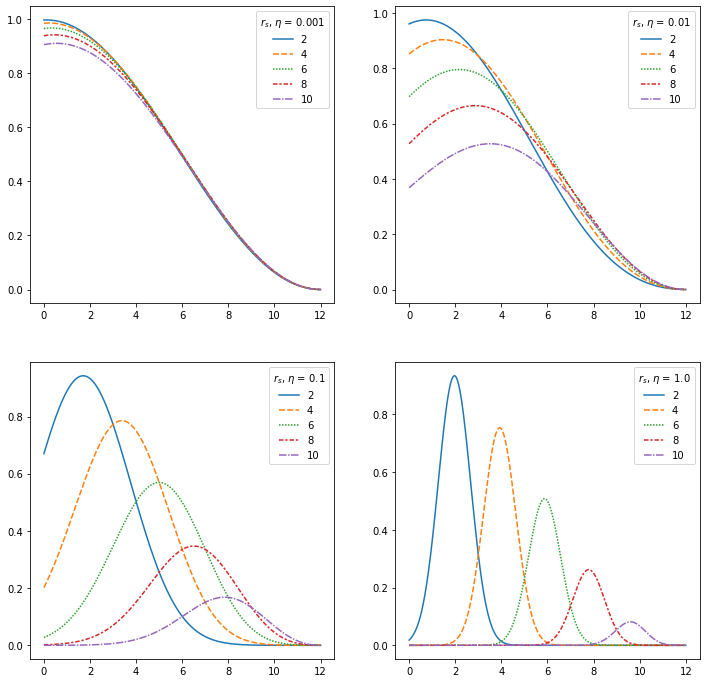

In [117]:
plot_radial(get_G_R(cutoff='cos'))

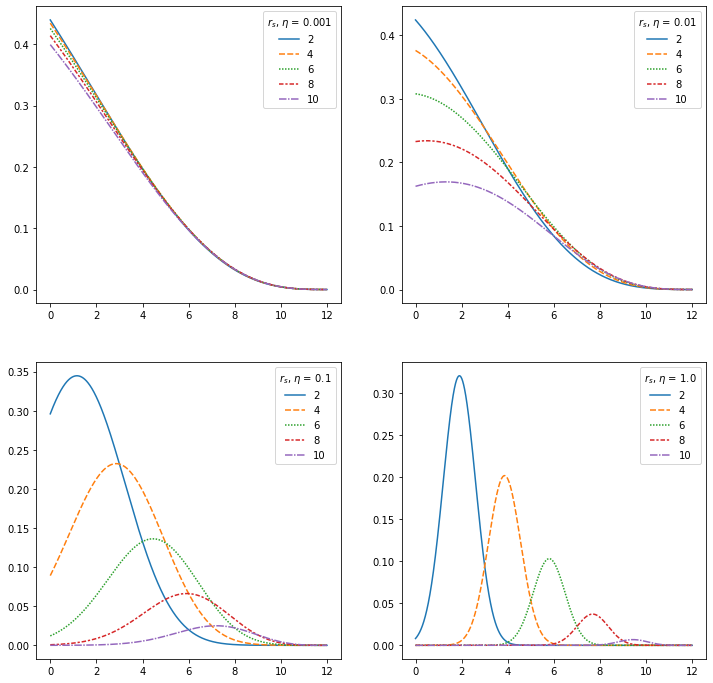

In [107]:
plot_radial(get_G_R(cutoff='tanh'))

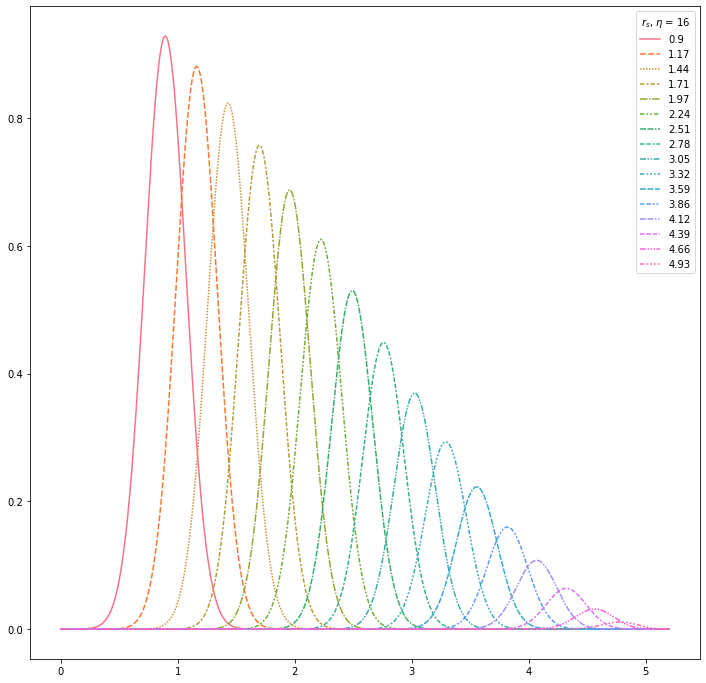

In [128]:
plot_radial(get_G_R(cutoff='cos', r_c=5.2, eta=np.array([16]), r_s=np.round(np.linspace(0.9, 4.93, 16), 2)))

In [130]:
df = nci.load_dfs(datasets=['NCIA_HB375x10'], exclude=True)
df['energies'] = df.energies.astype('float')

In [314]:
import nci
from itertools import product
from scipy.spatial import distance
data = nci.df_to_data(df)

def get_element_pairs(data, k=4):
    data = data[::2]
    element_pairs_all = {pair: [] for pair in product(range(4), range(4))}
    element_pairs_smallest = {pair: [] for pair in product(range(4), range(4))}

    idx = 0
    for idx in range(len(data)):
        s = data[idx]['species']
        C = data[idx]['coordinates']
        i = data[idx]['index_diff']
        n = len(s)
        PD = distance.cdist(C[:int(i)], C[int(i):])
        PS = torch.Tensor(np.array(list(product(s[:int(i)], s[int(i):])))).reshape(i, n-i, 2)
        for row_idx in range(i):
            for col_idx in range(n-i):
                element_pairs_all[tuple(np.array(PS[row_idx, col_idx]))].append(PD[row_idx, col_idx])

        k_smallest = np.argpartition(PD.ravel(), k)[:k]
        PD_smallest = PD.ravel()[k_smallest]
        PS_smallest = PS.reshape(-1, 2)[k_smallest]
        for small_idx in range(k):
            element_pairs_smallest[tuple(np.array(PS_smallest[small_idx]))].append(PD_smallest[small_idx])
    return element_pairs_all, element_pairs_smallest


def plot_element_pairs(element_pairs, smallest=False):
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    j = 0
    for pair, distances in element_pairs.items():
        ax = axs.ravel()[j]
        sns.histplot(distances, ax=ax)
        pair_name = '-'.join(map(lambda i: nci.dataset_elements['NCIA_HB375x10'][i], pair))
        ax.set_title(pair_name)
        if smallest:
            ax.set_xlim(1, 7)
        else:
            ax.set_xlim(1, 12)
        j += 1
    plt.tight_layout()

In [330]:
df.loc[df.scaling == 1]

,MoleculeA,MoleculeB,interaction_type,interaction,species,coordinates,index_diff,energies,scaling,reverse,C,O,N,H,id,dataset
8,acetic acid,acetaldehyde,HB,OH-O,"[tensor(1), tensor(3), tensor(3), tensor(0), t...","[[tensor(-1.6767), tensor(-0.1555), tensor(0.)...",[tensor(8)],-10.810,1.0,False,4,3,0,8,4,NCIA_HB375x10
9,acetaldehyde,acetic acid,HB,OH-O,"[tensor(3), tensor(1), tensor(1), tensor(0), t...","[[tensor(1.5546), tensor(0.9354), tensor(0.)],...",[tensor(7)],-10.810,1.0,True,4,3,0,8,4,NCIA_HB375x10
28,acetic acid,acetamide,HB,OH-O,"[tensor(1), tensor(3), tensor(3), tensor(0), t...","[[tensor(1.9588), tensor(0.0634), tensor(0.)],...",[tensor(8)],-19.325,1.0,False,4,3,1,9,14,NCIA_HB375x10
29,acetamide,acetic acid,HB,OH-O,"[tensor(1), tensor(2), tensor(1), tensor(3), t...","[[tensor(-3.4830), tensor(-0.1622), tensor(0.)...",[tensor(9)],-19.325,1.0,True,4,3,1,9,14,NCIA_HB375x10
48,acetic acid,acetone,HB,OH-O,"[tensor(1), tensor(3), tensor(3), tensor(0), t...","[[tensor(-2.0753), tensor(0.0740), tensor(0.04...",[tensor(8)],-10.585,1.0,False,5,3,0,10,24,NCIA_HB375x10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7449,furan,N-methylacetamide,VDW,VDW,"[tensor(1), tensor(3), tensor(1), tensor(1), t...","[[tensor(-1.6327), tensor(-0.3143), tensor(1.2...",[tensor(9)],-4.618,1.0,True,7,2,1,11,3724,NCIA_HB375x10
7468,phenol,methylisocyanide,VDW,VDW,"[tensor(0), tensor(0), tensor(0), tensor(0), t...","[[tensor(-1.3416), tensor(-1.4205), tensor(-1....",[tensor(13)],-6.836,1.0,False,8,1,1,9,3734,NCIA_HB375x10
7469,methylisocyanide,phenol,VDW,VDW,"[tensor(1), tensor(2), tensor(1), tensor(0), t...","[[tensor(1.8654), tensor(1.6469), tensor(-0.83...",[tensor(6)],-6.836,1.0,True,8,1,1,9,3734,NCIA_HB375x10
7488,water,methylisocyanide,VDW,VDW,"[tensor(3), tensor(0), tensor(0), tensor(0), t...","[[tensor(2.1176), tensor(-0.0640), tensor(0.)]...",[tensor(3)],-4.375,1.0,False,2,1,1,5,3744,NCIA_HB375x10


In [320]:
element_pairs_all, element_pairs_smallest_2 = get_element_pairs(data, k=2)
element_pairs_all, element_pairs_smallest_5 = get_element_pairs(data, k=5)

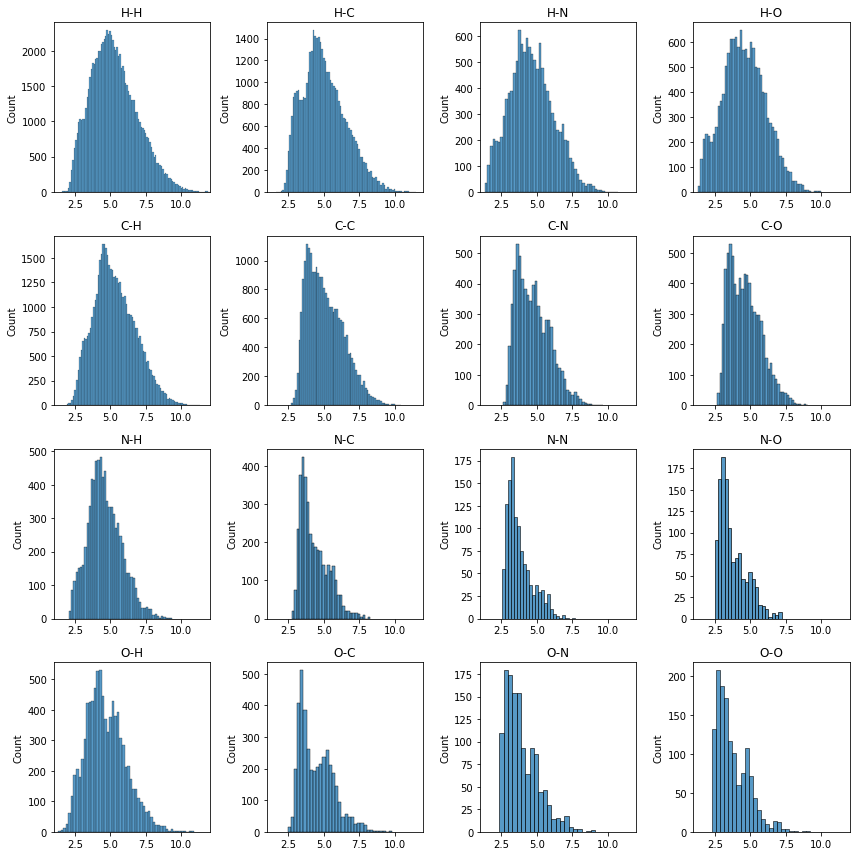

In [316]:
plot_element_pairs(element_pairs_all)

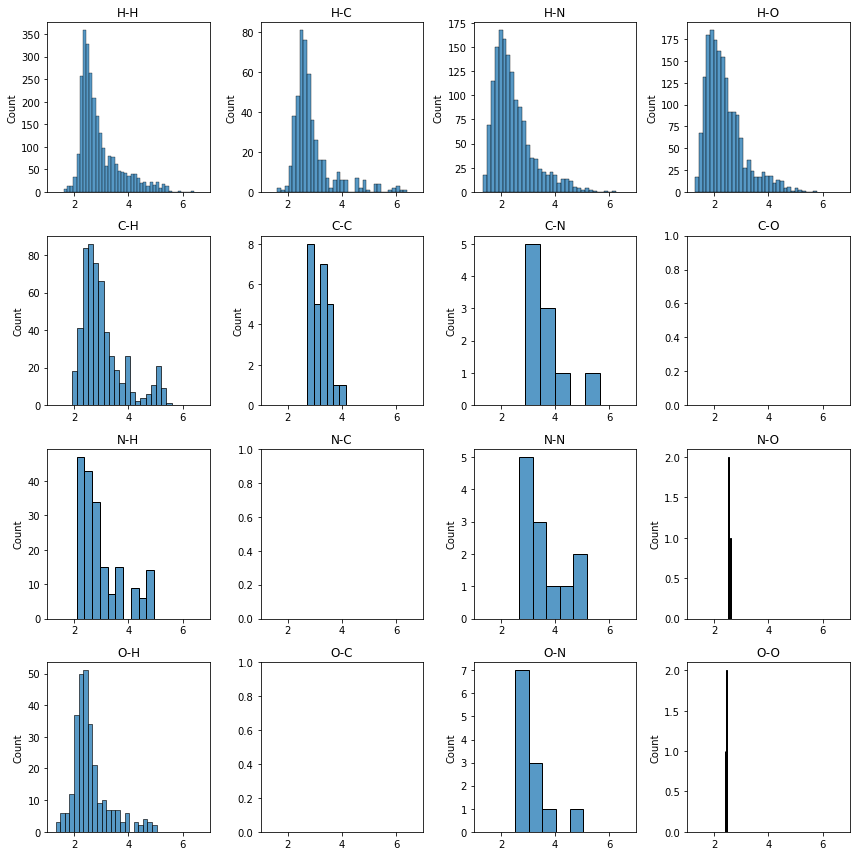

In [321]:
plot_element_pairs(element_pairs_smallest_2, smallest=True)

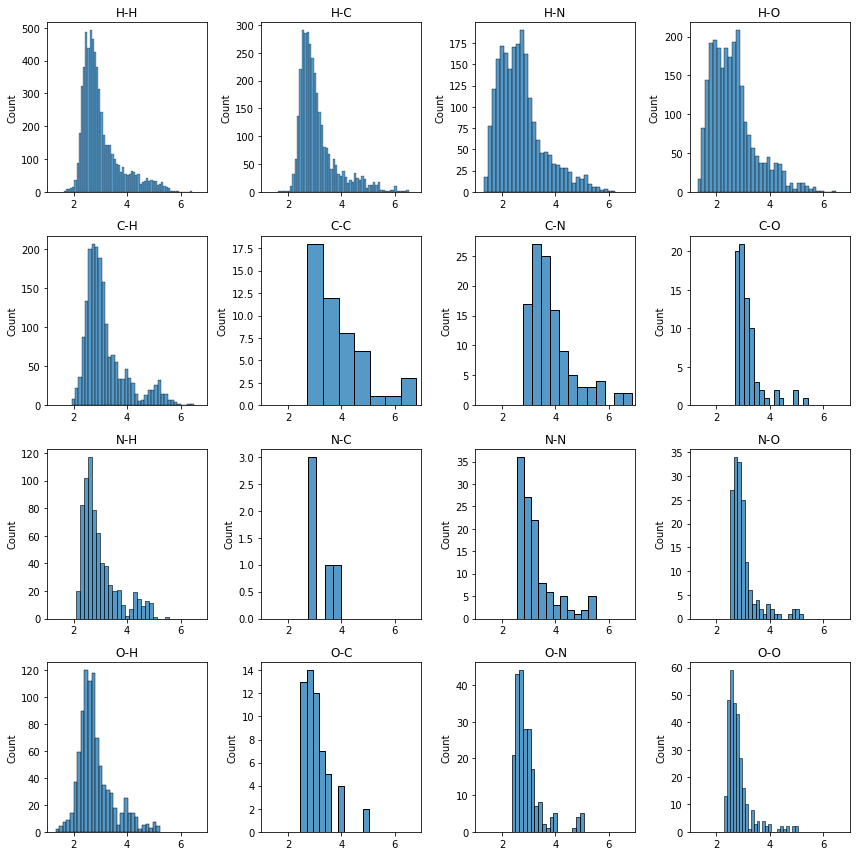

In [322]:
plot_element_pairs(element_pairs_smallest_5, smallest=True)